# Visualizations of Model Performance

In this tutorial, we will use some of the tools provided by **[AMPL](https://github.com/ATOMScience-org/AMPL)** to visualize the model training process and the performance of the final model.
Some of the tools we'll apply here are only applicable to certain classes of models; as we go along we will indicate where each function can be applied.

The tutorial will present the following functions, all from the `perf_plots` module:
- [plot_perf_vs_epoch](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_perf_vs_epoch)
- [plot_pred_vs_actual](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_pred_vs_actual)
- [plot_confusion_matrices](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_confusion_matrices)
- [plot_model_metrics](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_model_metrics)
- [plot_ROC_curve](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_ROC_curve)
- [plot_prec_recall_curve](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_prec_recall_curve)

We will use the same training dataset and **scaffold split** as in **Tutorial 3, "Train a Simple Regression Model**", to create some **neural network models** and visualize their iterative training
process. Later, we'll generate a binary classification dataset based on the same data, so we can train **classification models** and show the visualizations that are 
specific to classifiers. For starters, let's import some standard packages and modules:

In [2]:
import pandas as pd
import numpy as np
import json

# Set for less chatty log messages
import logging
logger = logging.getLogger('ATOM')
logger.setLevel(logging.INFO)

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_plots as pp

2024-07-19 15:22:53.491299: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 15:22:53.493623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 15:22:53.529688: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 15:22:53.530662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 15:22:54.157736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

## Visualizing the Training Process for a Neural Network Regression Model
When you train a **neural network model**, **[AMPL](https://github.com/ATOMScience-org/AMPL)** makes a series of iterations through the entire training subset of your curated dataset; each iteration is called an **epoch**. At the end of each epoch, **[AMPL](https://github.com/ATOMScience-org/AMPL)** saves the model parameters (i.e., the weights of 
each network connection) in a checkpoint file. It then computes and stores a set of metrics describing the model's performance at that stage of training: the $R^2$ value for regression models and the **ROC AUC** for classification models. By
default these metrics are used to select the epoch yielding the best validation set performance; but you may choose a different metric by setting
the `model_choice_score_type` parameter. The metrics are evaluated separately for the training, validation and test subsets. Generally, the training set metrics continue to improve with more epochs, while the validation and test set
metrics reach a peak and then decline, as the model becomes overfitted to the training subset. The function `plot_perf_vs_epoch` allows you to 
visualize this process.

The code below will train a simple fully-connected neural network on the **[SLC6A3](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL238/)** dataset. By default, **[AMPL](https://github.com/ATOMScience-org/AMPL)** uses an **early stopping** algorithm to terminate training if the chosen 
validation set metric peaks and does not improve further after a certain number of epochs, set by the `early_stopping_patience` parameter. Here we tell **[AMPL](https://github.com/ATOMScience-org/AMPL)** to optimize the **root mean squared error (RMSE)** rather than $R^2$, to train for up to 
100 epochs, and to stop training if the **RMSE** does not improve for 20 epochs after reaching a minimum.

In [3]:
dataset_file = 'dataset/final_data_curated.csv'
output_dir='dataset/final_model'

response_col = "Y"
id_col = "compound_id"
smiles_col = "base_rdkit_smiles"
split_uuid = "f346a459-b654-4e1a-9bb4-8c4207a19b1f"

params = {
        # dataset info
        "dataset_key": dataset_file,
        "id_col": id_col,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        # splitting
        "previously_split": "True",
        "split_uuid" : split_uuid,
        "splitter": 'scaffold',
        "split_valid_frac": "0.1",
        "split_test_frac": "0.1",
        # featurization
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
        # model training parameters
        "model_type": "NN",
        "prediction_type": "regression",
        "layer_sizes": "512,256,128",
        "dropouts": "0.15, 0.15, 0.15",
        "max_epochs": "100",
        "early_stopping_patience": "20",
        "model_choice_score_type": "rmse",
        "verbose": "True",
        "result_dir": output_dir,
        "verbose": "True",
    }

ampl_param = parse.wrapper(params)
regr_pipe = mp.ModelPipeline(ampl_param)
regr_pipe.train_model()

INFO:ATOM:Using prefeaturized data; number of features = 200
/opt/atomsci-env/lib/python3.8/site-packages/deepchem/data/datasets.py:473: RuntimeWarning: overflow encountered in multiply
  X_m2 += dx * (X - X_means)
INFO:ATOM:Wrote transformers to dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/transformers.pkl
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming feature data
INFO:ATOM:Total score for epoch 0 is -1.13
INFO:ATOM:Epoch 0: training r2_score = 0.260, validation r2_score = -0.026, test r2_score = -0.072
INFO:ATOM:Epoch 1: training r2_score = 0.389, validation r2_score = -0.094, test r2_sco

['dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint1.pt', 'dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint2.pt', 'dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint3.pt', 'dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint4.pt', 'dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint5.pt']
dataset/final_model/final_data_curated/NN_computed_descriptors_scaffold_regression/5b3016a7-3025-4f4d-bbd7-d407c4643460/model/checkpoint1.pt


We now use the `plot_perf_vs_epoch` function to show how the performance metrics change during training:

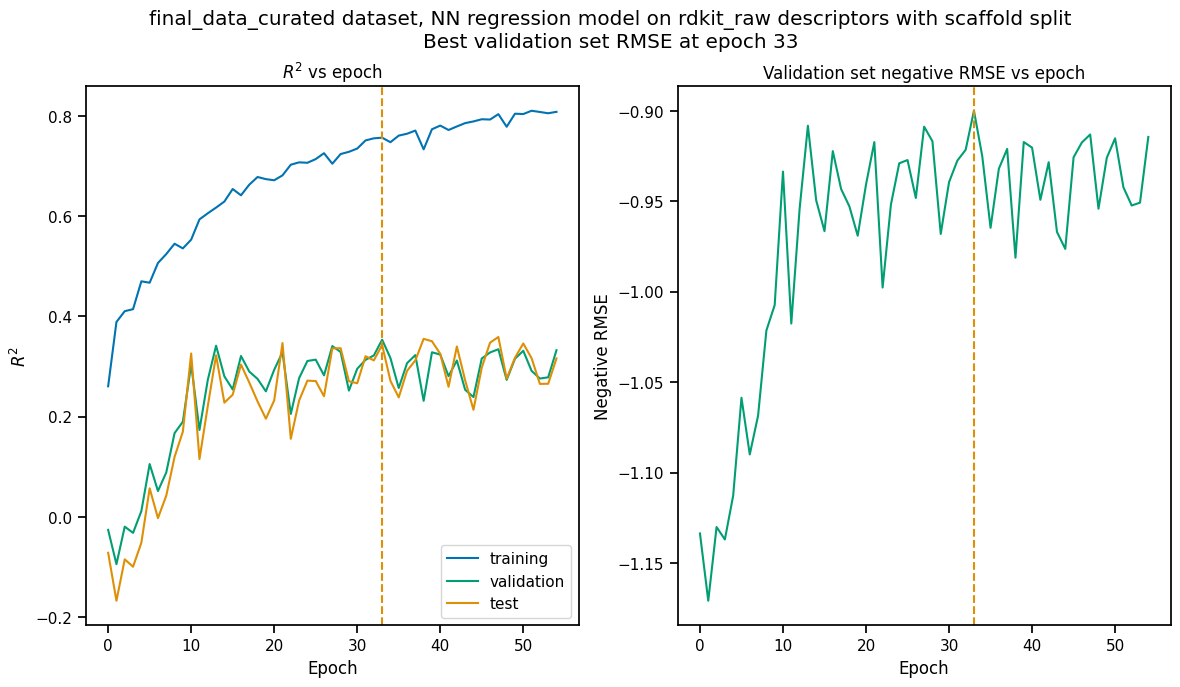

In [4]:
pp.plot_perf_vs_epoch(regr_pipe)

The vertical dashed lines indicate the epoch at which the validation set **RMSE** was minimized; the parameters retrieved from the checkpoint file for this epoch are the ones saved in the model file.

When the model is trained to optimize the default score type ($R^2$ or **ROC AUC**), only the left hand plot is drawn. Note that the epoch with the maximum $R^2$ may or may not be the same as the one that minimizes **RMSE**. 

>**Note:**
>*The `pipe` argument to `plot_perf_vs_epoch` is a `ModelPipeline` object for a model you have trained in your current Python session; it doesn't work with a previously saved model that you've loaded using a function like `create_prediction_pipeline_from_file`*.

## Comparing Predicted with Actual Values by Split Subset
There are times when a single number like $R^2$ or **RMSE** is not enough to give you a feeling for how well your model is performing (or more importantly, where it is failing). For this reason, **[AMPL](https://github.com/ATOMScience-org/AMPL)** provides a function to produce a scatterplot of predicted vs actual values for each split subset, as shown below.

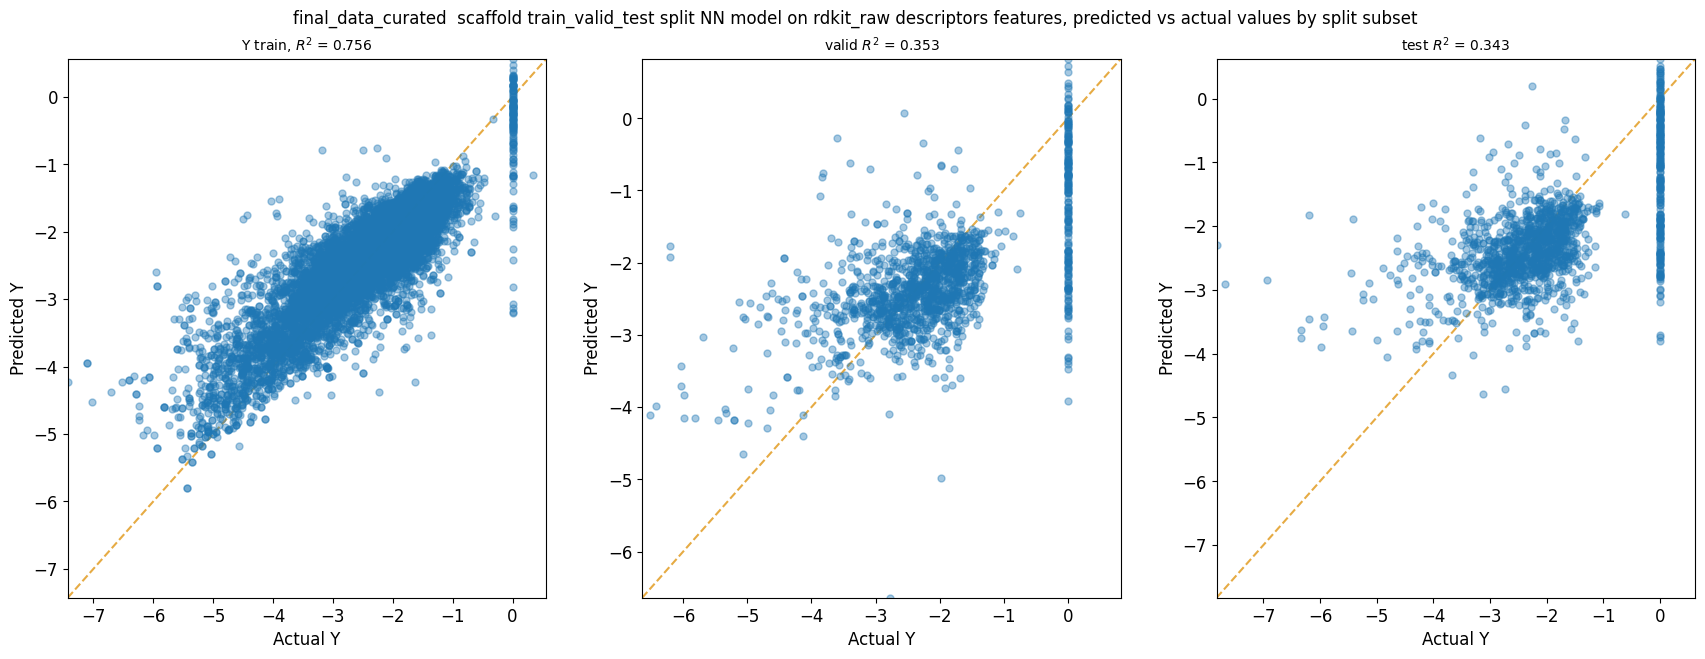

In [5]:
pp.plot_pred_vs_actual(regr_pipe)

The plots highlight a couple of interesting features of the training dataset. First, the vertical lines of points with actual value 5 represent 
censored data, where the $K_i$ values were reported as "> 10 µM" because the maximum concentration tested 
did not allow higher $K_i$ values to be measured precisely. Second, you'll note that higher $K_i$ values tend to be underpredicted and lower $K_i$'s are overpredicted, even for the training
subset. This suggests that model performance could be improved by further hyperparameter optimization.

As with `plot_perf_vs_epoch`, the `plot_pred_vs_actual` function only works with "live" `ModelPipeline` objects trained in the current Python session. However, there is an alternative
version of this function specifically for saved models. We'll try out this function on the best **random forest** model from the hyperparameter searches performed in **Tutorial 5, "Hyperparameter Optimization"**:

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"
INFO:ATOM:Featurization = DynamicFeaturization with ecfp features


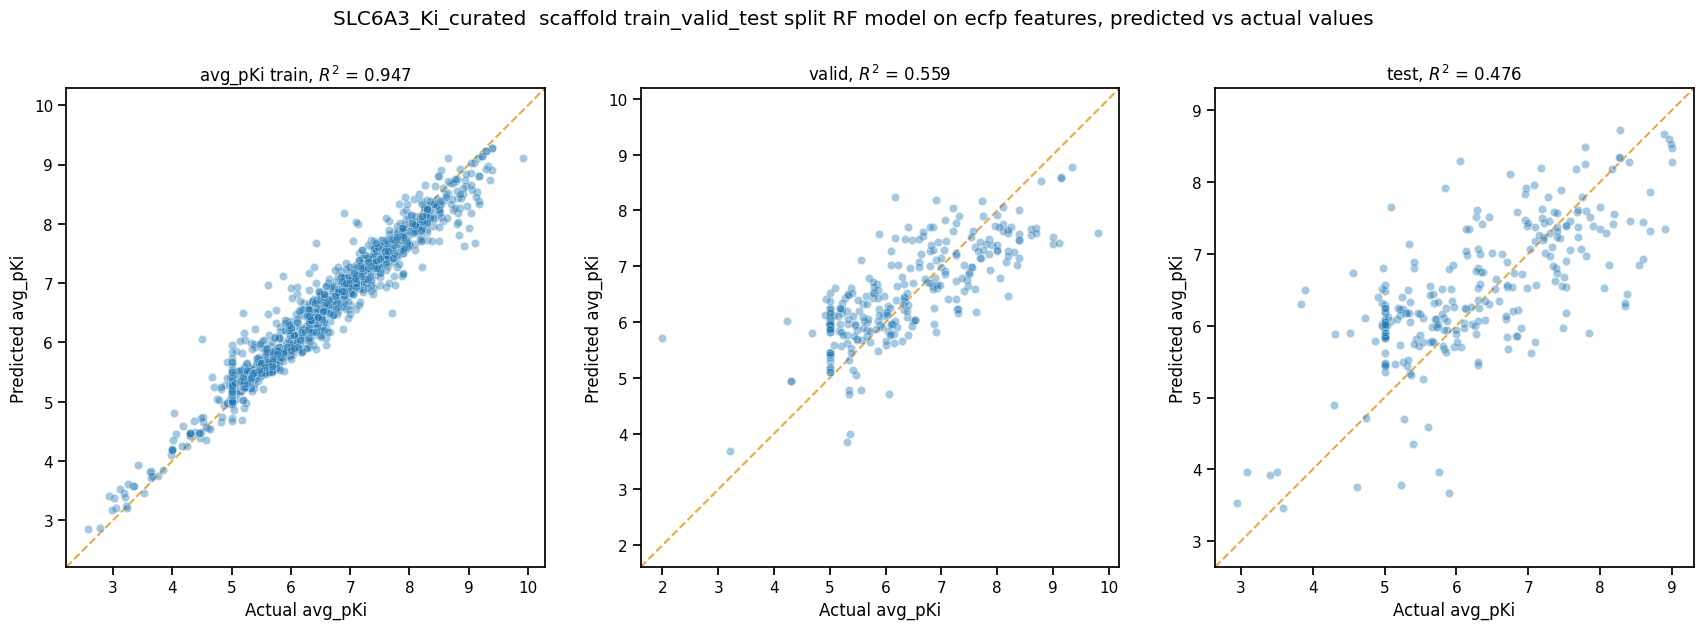

In [5]:
pp.plot_pred_vs_actual_from_file('dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz')

The points predicted by the optimized RF model are indeed closer to the identity line, as one would expect from the higher $R^2$ scores. Although the lower $K_i$ values are still overpredicted in the validation and test sets, the spread of predicted values above the identity line is much reduced.

## Visualizations of Classification Model Performance
Classification models are trained to assign compounds to one of a set of discrete, often binary classes: active/inactive, agonist/antagonists of particular receptors, etc. 
They are evaluated using different performance metrics than regression models; in most cases these call for completely different visualization tools.
In this section of the tutorial, we will construct a binary classification dataset, train a model against it, and use it to demonstrate some of the visualizations provided by **[AMPL](https://github.com/ATOMScience-org/AMPL)** specifically for classification models.

To create a binary classification dataset, we will simply add a column called 'active' to the **[SLC6A3](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL238/)**  $K_i$ dataset containing "1" for compounds with $pK_i \ge 8$ and "0" for all others:

In [11]:
dset_df = pd.read_csv('dataset/final_data_curated.csv')
dset_df['active'] = [int(y <= -2) for y in dset_df.Y.values]
classif_dset_file = 'dataset/final_data_class_neg2.csv'
dset_df.to_csv(classif_dset_file, index=False)
dset_df.active.value_counts()

active
1    8609
0    5836
Name: count, dtype: int64

Note that we have purposely created an imbalanced dataset, with many more inactive than active compounds. This provides us an opportunity to apply some of the tools **[AMPL](https://github.com/ATOMScience-org/AMPL)** supplies to deal with this common situation.

Next we will split the dataset by scaffold:

In [7]:
output_dir='dataset/final_models'
params = {
    # dataset info
    "dataset_key" : classif_dset_file,
    "response_cols" : "active",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": output_dir,

    # splitting
    #"split_only": "True",
    "previously_split": "True",
    "splitter": 'scaffold',
    "split_valid_frac": "0.1",
    "split_test_frac": "0.1",

    # featurization & training params
    "featurizer": "compu",
}
pparams = parse.wrapper(params)
split_pipe = mp.ModelPipeline(pparams)
split_uuid = split_pipe.split_dataset()

It is often a good idea, especially with imbalanced datasets, to check that the class proportions are similar between the split subsets. The function `plot_split_subset_response_distrs`, which we encountered in **Tutorial 2, "Splitting Datasets for Validation and Testing"**, provides a way to do this.
Note that when the `prediction_type` parameter is set to `classification`, the function produces a bar graph rather than a density plot:

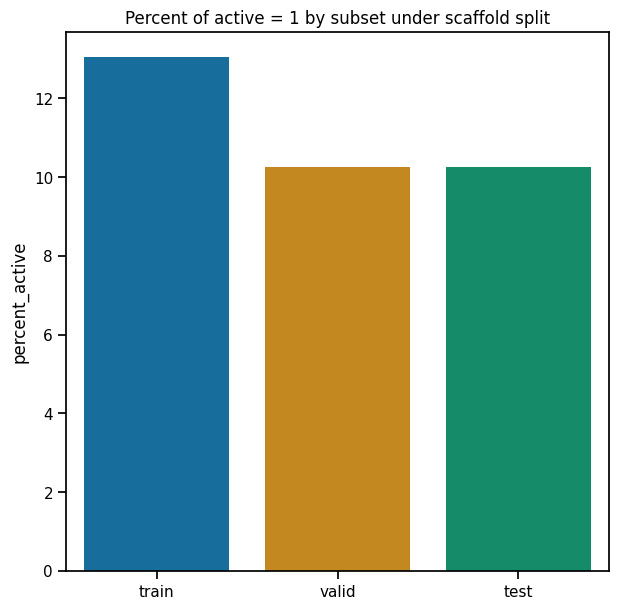

In [8]:
import atomsci.ddm.utils.split_response_dist_plots as srdp
split_params = {
    "dataset_key" : classif_dset_file,
    "smiles_col" : "base_rdkit_smiles",
    "prediction_type": "classification",
    "response_cols" : "active",
    "split_uuid": split_uuid,
    "splitter": 'scaffold',
}
srdp.plot_split_subset_response_distrs(split_params)

The proportion of actives is fairly even across the split subsets. We will check later to see if the higher percentage of actives in the training set causes the model to predict too many false positives.

Now we will train a **neural network** to predict compound classes using **[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)** fingerprints as features:

In [9]:
params = {
    # dataset info
    "dataset_key" : classif_dset_file,
    "response_cols" : "active",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": output_dir,

    # splitting
    "split_uuid": split_uuid,
    "previously_split": "True",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "ecfp",
    "prediction_type": "classification",
    "model_type": "NN",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "learning_rate": "0.0002",
    "max_epochs": "100",
    "early_stopping_patience": "20",
    "verbose": "True",
}
pparams = parse.wrapper(params)
classif_pipe = mp.ModelPipeline(pparams)
classif_pipe.train_model()

['dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint1.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint2.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint3.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint4.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint5.pt']
dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/5aae26e9-1bbd-4f6c-8662-c7baae078bee/model/checkpoint1.pt


As we did before for a regression model, we use the function `plot_perf_vs_epoch` to display the changes in the default performance metric over successive epochs of training. In this case only one plot is drawn because we are using the default metric (**ROC AUC**) evaluated on the validation set to decide when to stop training.

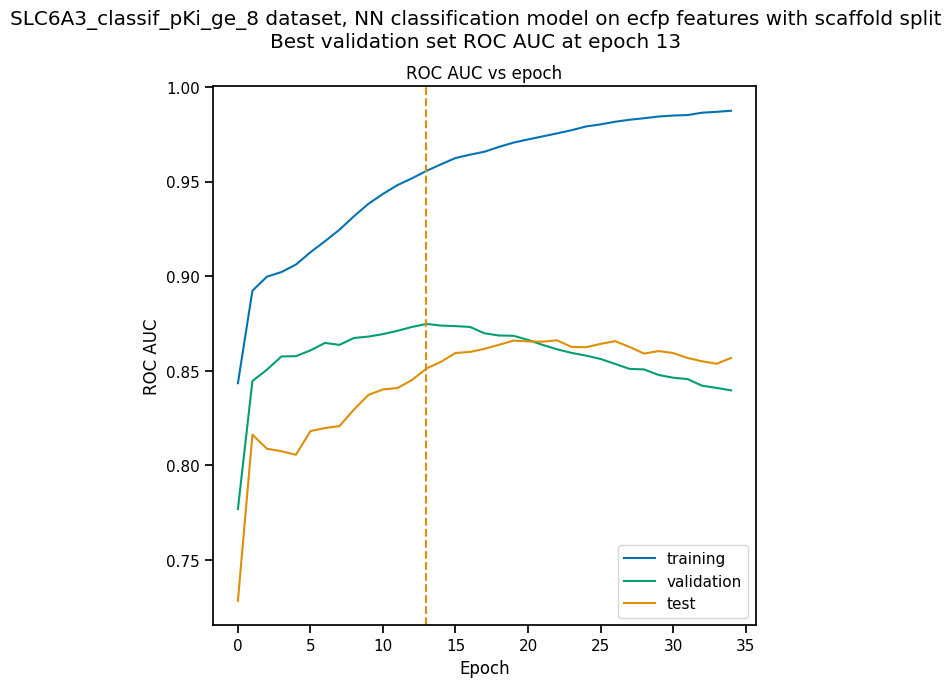

In [10]:
pp.plot_perf_vs_epoch(classif_pipe)

Note that the validation set **ROC AUC** peaked at only 13 epochs, at around 0.88. Although this seems at first glance like a good result, we need to remind ourselves that our dataset
is highly unbalanced, with 1597 inactives and 222 actives. Therefore, a 'dumb' classifier that predicts every compound to be inactive will be correct, on average, 1597/(1597+222) = 88% of the time. We need to look at some other metrics to see if our model is doing any better than a dumb classifier.

First, we will plot a **[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)** for each split subset. A confusion matrix is simply a table that shows the numbers of compounds
with each possible class that are predicted to belong to that class and each other class. **[AMPL](https://github.com/ATOMScience-org/AMPL)** provides the function `plot_confusion_matrices` to draw the confusion matrix for each subset:

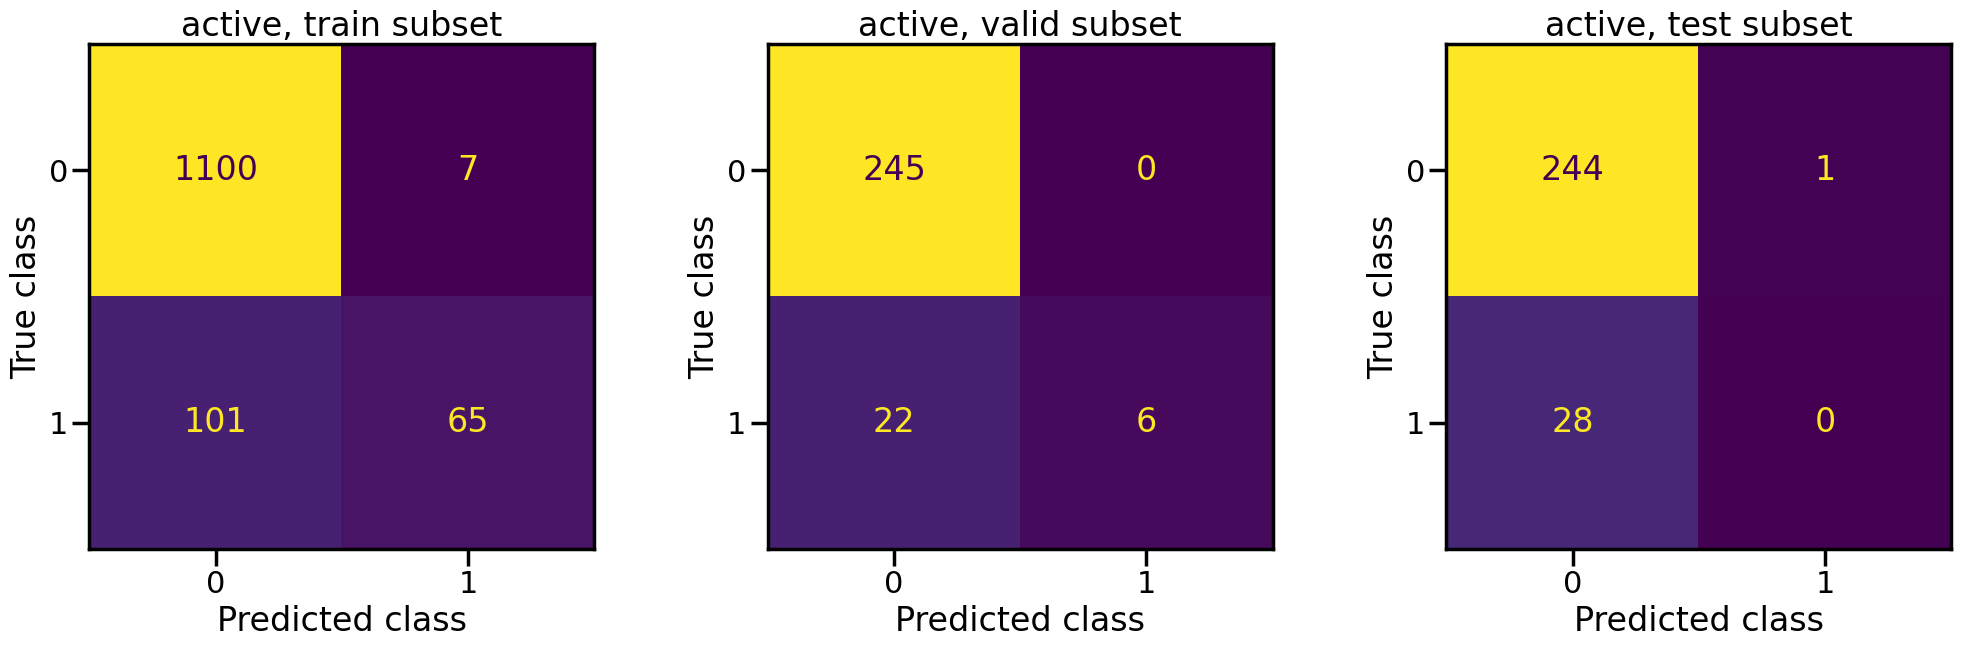

In [11]:
pp.plot_confusion_matrices(classif_pipe)

The `confusion matrices` show that the model is behaving not much differently from a dumb classifier. In the validation set, it predicts the inactive class 97% of the time, even though inactives
are only 88% of the compounds.

**[AMPL](https://github.com/ATOMScience-org/AMPL)** calculates many other metrics for classification models, which may provide additional insight into how a model is performing. We can display a barplot of metric values for each subset
using the function `plot_model_metrics`. For an unbalanced dataset, the **[precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)** metrics are far more sensitive indicators 
of performance than accuracy or **ROC AUC**. Here the accuracy is about 0.9, about what would be expected from a dumb classifier, for all 3 subsets; while the validation set precision and recall 
are 100% and 21% respectively. We can also see this from the confusion matrix: all of the predicted actives are indeed active; but only 6/28 of the true actives are predicted to be active.

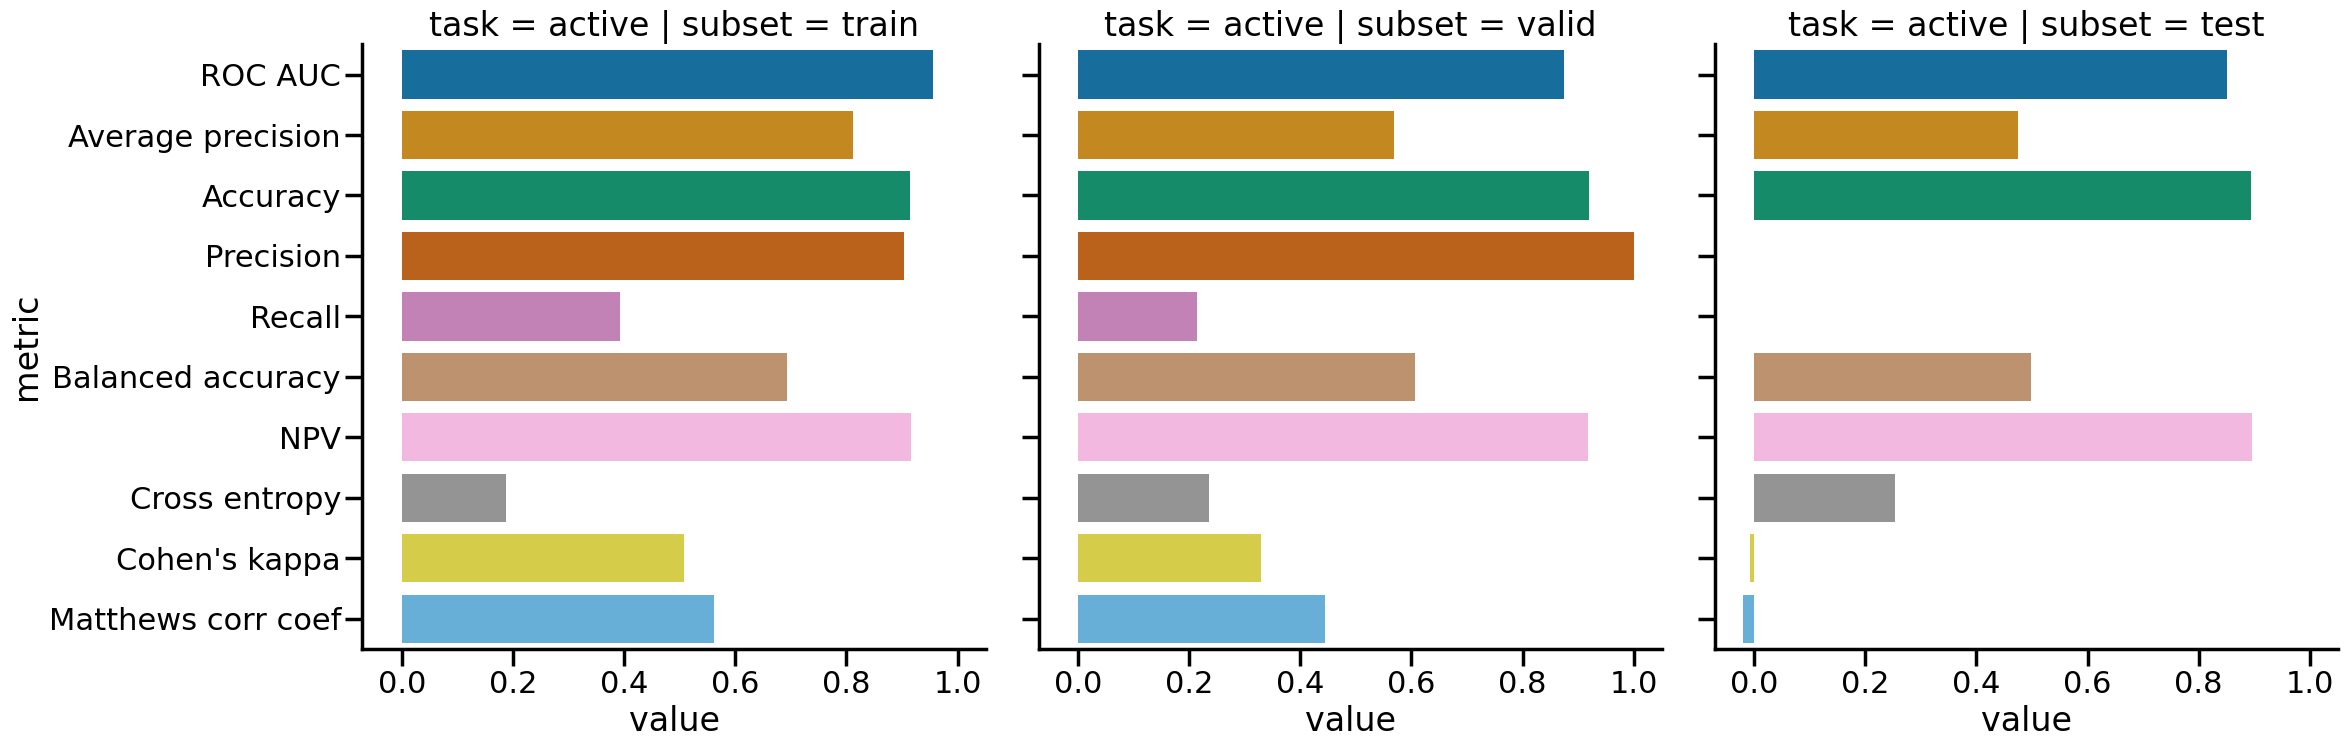

In [12]:
pp.plot_model_metrics(classif_pipe, plot_size=8)

Given the rather mediocre recall performance of our model, we would like to try training a new model that has better recall without sacrificing too much precision. One way to do this is to change the `model_choice_score_type` parameter to optimize the number of training epochs for a metric that balances precision and recall. **[Balanced accuracy](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)** and the **[Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Phi_coefficient)** are two such metrics often used for this purpose.
We'll try out using the `MCC`, with all other parameters left the same.

['dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint1.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint2.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint3.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint4.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint5.pt']
dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ee6a8fbb-c3f3-4a17-84c1-ffa0ad75a703/model/checkpoint1.pt


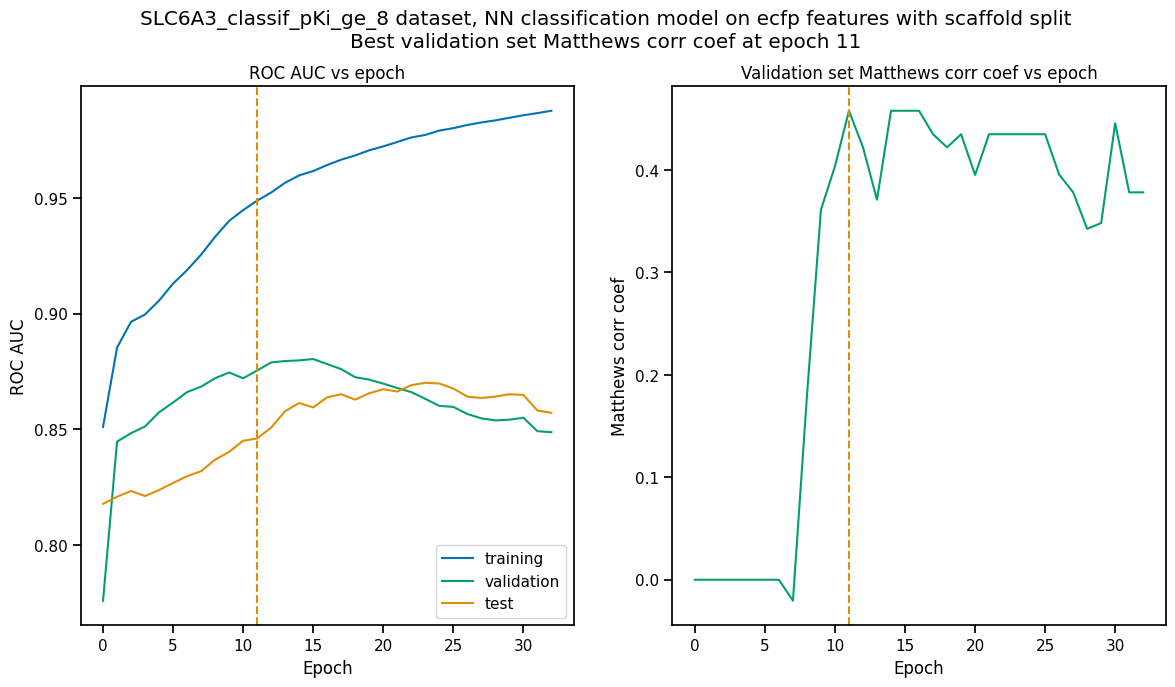

In [13]:
params = {
    # dataset info
    "dataset_key" : classif_dset_file,
    "response_cols" : "active",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": output_dir,

    # splitting
    "split_uuid": split_uuid,
    "previously_split": "True",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "ecfp",
    "prediction_type": "classification",
    "model_type": "NN",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "learning_rate": "0.0002",
    "max_epochs": "100",
    "early_stopping_patience": "20",
    "verbose": "True",
    "model_choice_score_type": "mcc",
}
pparams = parse.wrapper(params)
mcc_pipe = mp.ModelPipeline(pparams)
mcc_pipe.train_model()
pp.plot_perf_vs_epoch(mcc_pipe)

Note that the maximum validation set MCC is achieved at epoch 11, while the **ROC AUC** is maximized much later at epoch 15. In general, the metric selected for `model_choice_score_type`
has a much greater impact for classification models than for regression models.

Now let's look at the performance metrics for the MCC-optimized model:

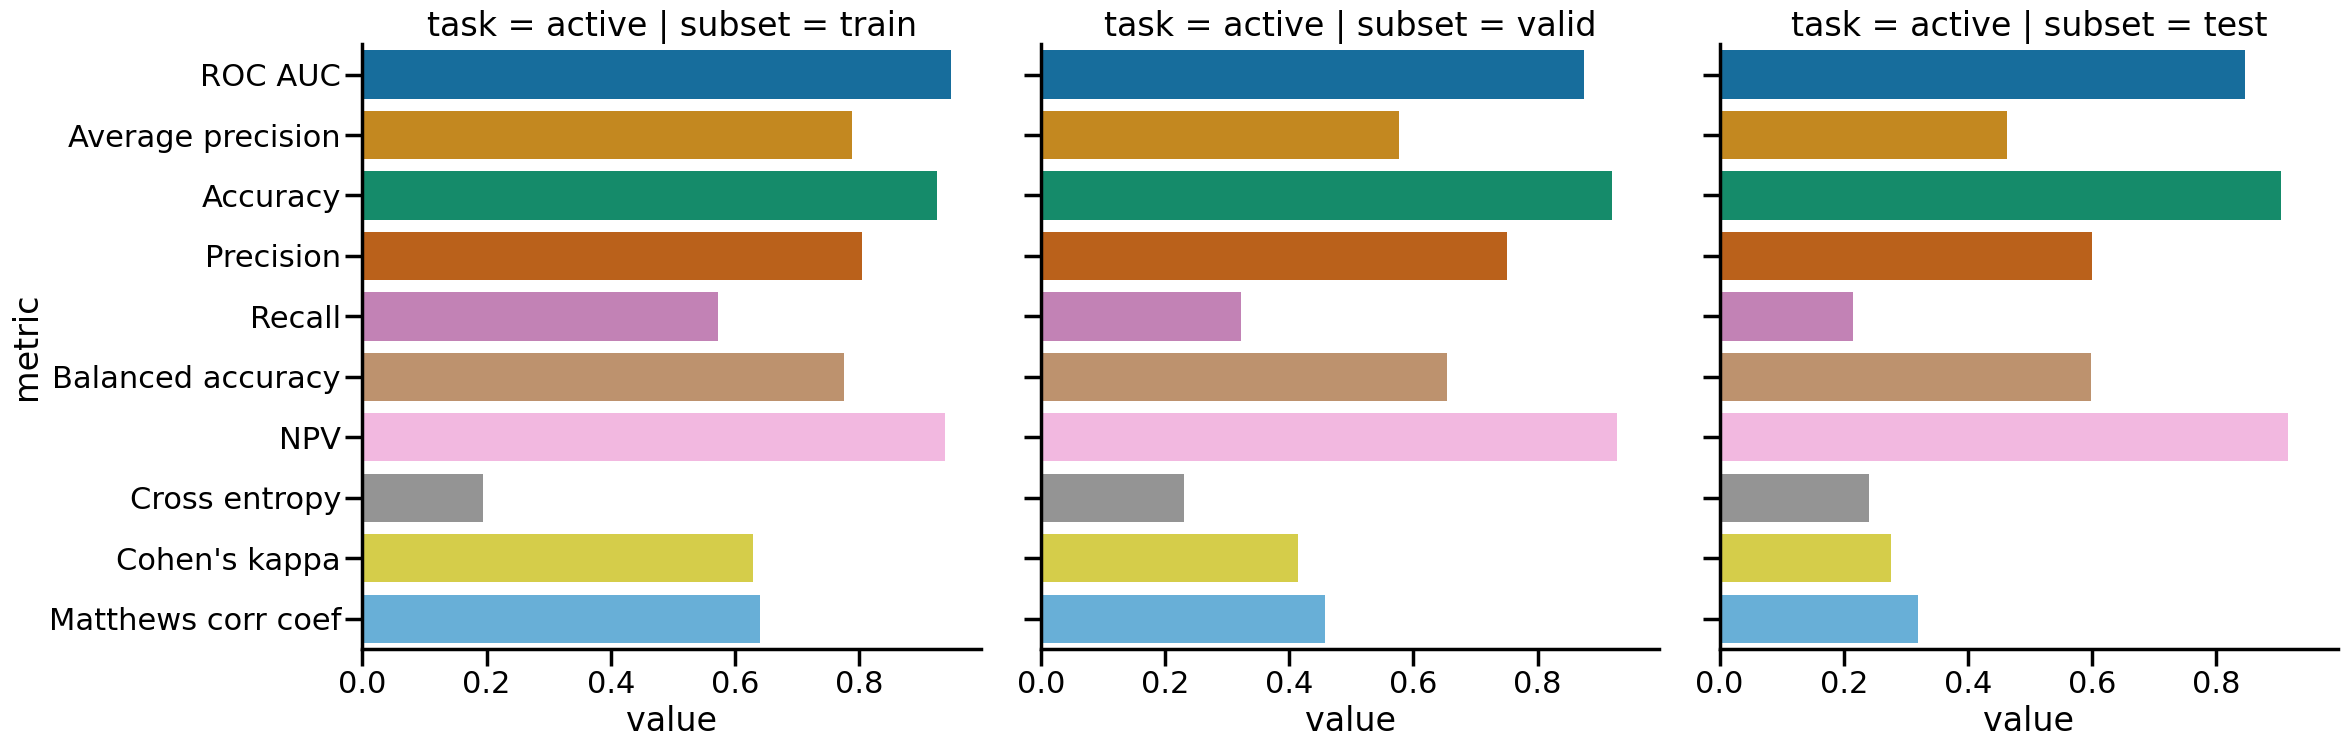

In [14]:
pp.plot_model_metrics(mcc_pipe, plot_size=8)

We see that the recall is improved slightly, from 0.21 to about 0.30; while the precision has dropped from 1.0 to 0.6. This may be acceptable or not, depending on your situation. Do you want to minimize
the cost of synthesizing and testing compounds that may turn out to be false positives? Or do you want to minimize the chance that your model will overlook a potential blockbuster drug? The 
numerous selection metrics supported by **[AMPL](https://github.com/ATOMScience-org/AMPL)** give you flexibility to tailor model training according to your priorities.

As an aside, **[SLC6A3](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL238/)**  provides another option for dealing with unbalanced classification datasets: the `weight_transform_type` parameter. Setting this parameter to "balancing" changes the way the cost
function to be minimized during training is calculated so that compounds belonging to the minority class are given higher weight in the cost function. This modification eliminates the incentive
for classifiers to always predict the majority class. This parameter can be combined with the `model_choice_score_type` parameter to yield different effects on the precision and recall metrics:

['dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint1.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint2.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint3.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint4.pt', 'dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint5.pt']
dataset/SLC6A3_models/SLC6A3_classif_pKi_ge_8/NN_ecfp_scaffold_classification/ffe7fda2-5c4e-4e7d-9fef-8bb3e4729f92/model/checkpoint1.pt


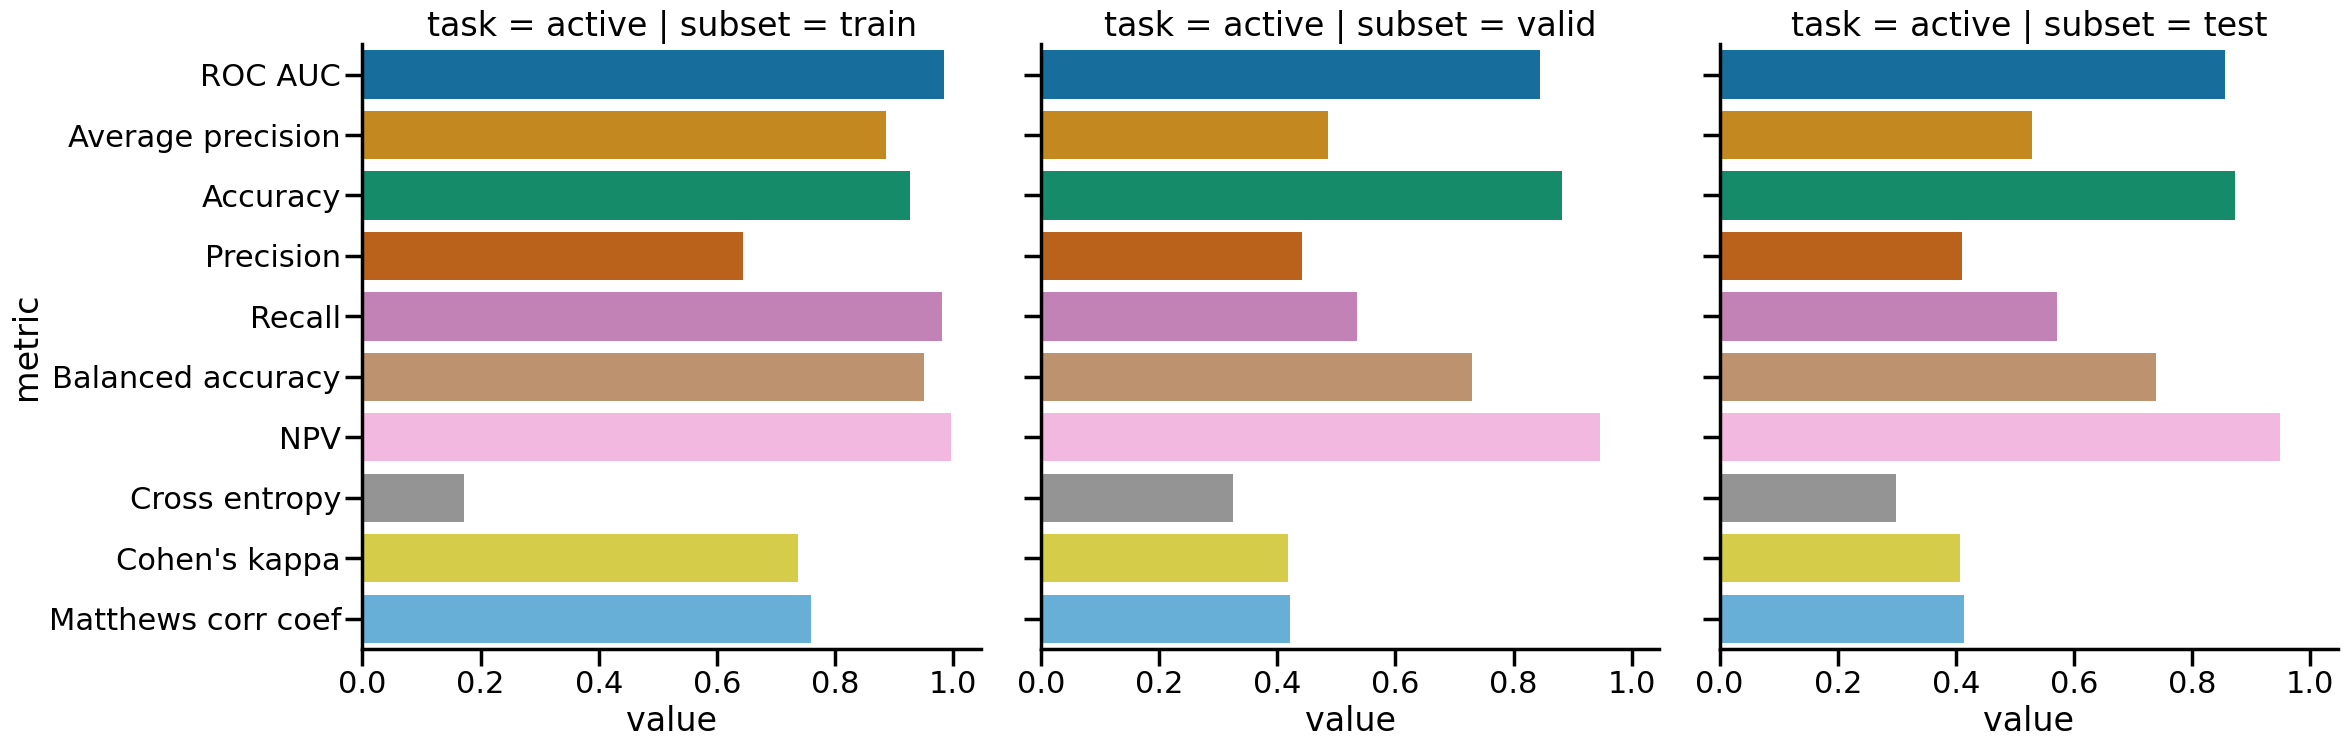

In [15]:
params = {
    # dataset info
    "dataset_key" : classif_dset_file,
    "response_cols" : "active",
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": output_dir,

    # splitting
    "split_uuid": split_uuid,
    "previously_split": "True",
    "splitter": 'scaffold',
    "split_valid_frac": "0.15",
    "split_test_frac": "0.15",

    # featurization & training params
    "featurizer": "ecfp",
    "prediction_type": "classification",
    "model_type": "NN",
    "layer_sizes": "128,64",
    "dropouts": "0.3,0.3",
    "learning_rate": "0.0002",
    "max_epochs": "100",
    "early_stopping_patience": "20",
    "verbose": "True",
    "model_choice_score_type": "mcc",
    "weight_transform_type": "balancing",
}
pparams = parse.wrapper(params)
mcc_wts_pipe = mp.ModelPipeline(pparams)
mcc_wts_pipe.train_model()
pp.plot_model_metrics(mcc_wts_pipe, plot_size=8)

The new model trained using both parameters has even better recall, at the cost of a small reduction in precision.

Incidentally, the detailed metrics underlying the plots above can be obtained as a nested dictionary using the function `get_metrics_from_model_pipeline`:

In [16]:
metrics_dict = pp.get_metrics_from_model_pipeline(mcc_wts_pipe)
print(json.dumps(metrics_dict, indent=4))

{
    "active": {
        "train": {
            "roc_auc": 0.9839738357222929,
            "prc_auc": 0.8866116456224803,
            "accuracy": 0.9269442262372348,
            "precision": 0.6442687747035574,
            "recall": 0.9819277108433735,
            "bal_accuracy": 0.9503134489176217,
            "npv": 0.9970588235294118,
            "cross_entropy": 0.17187009506671735,
            "kappa": 0.7365568068786424,
            "MCC": 0.759997950847689,
            "confusion_matrix": [
                [
                    [
                        1017,
                        90
                    ],
                    [
                        3,
                        163
                    ]
                ]
            ]
        },
        "valid": {
            "roc_auc": 0.8443148688046648,
            "prc_auc": 0.48576226827635516,
            "accuracy": 0.8827838827838828,
            "precision": 0.4411764705882353,
            "recall": 0.535714285714285

## Plotting ROC and Precision-Recall Curves
A **[receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)** curve is a commonly used plot for 
assessing the performance of a binary classifier. It is generated from lists of true classes and predicted probabilities for the positive
class by varying a threshold on the class probability, classifying as positive the compounds with probability greater than that threshold, 
and computing the fractions of true and false positives (the **true positive rate (TPR)** and **false positive rate (FPR)**). The ROC curve plots
the resulting TPRs against the corresponding FPRs; the **ROC AUC** is simply the area under the ROC curve. The ROC curve for a completely 
random classifier will be close to a diagonal line running from (0,0) to (1,1), with AUC = 0.5.  A perfect classifier has a ROC curve
that follows the Y axis and then runs horizontally across the top of the plot.

**[AMPL](https://github.com/ATOMScience-org/AMPL)** provides the function `plot_ROC_curve`, which takes a `ModelPipeline` object as its main argument; it plots separate curves for the
training, validation and test sets on the same axes.

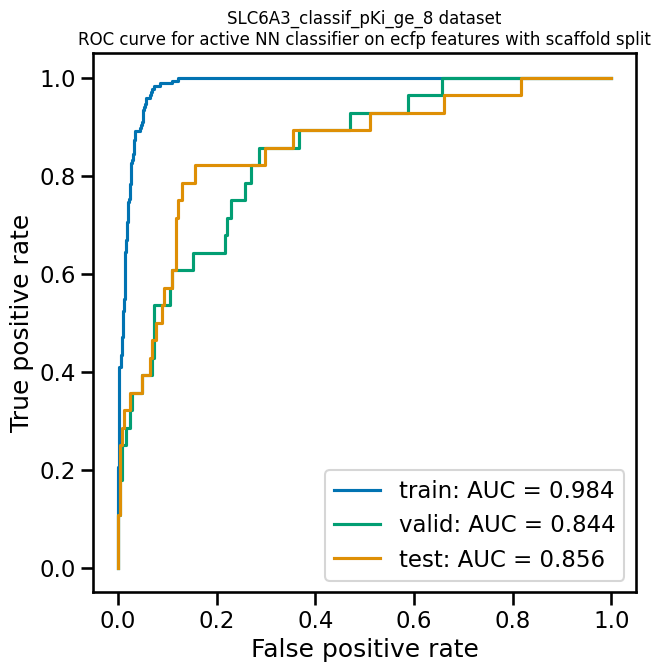

In [17]:
pp.plot_ROC_curve(mcc_wts_pipe)

A **[precision-recall curve](https://en.wikipedia.org/wiki/Precision_and_recall)** is generated using a similar thresholding process, except that
the metrics computed and plotted for each threshold are the precision and recall. Although the precision generally decreases with increasing
recall, it usually doesn't decrease monotonically, especially for imbalanced datasets where the validation and test sets have very small 
numbers of active compounds. 

**[AMPL](https://github.com/ATOMScience-org/AMPL)** provides the function `plot_prec_recall_curve` to draw precision vs recall curves for the training, validation and test sets
on one plot.  The area under the curve, also known as the `average precision (AP)`, is computed as well and shown in the figure legend.

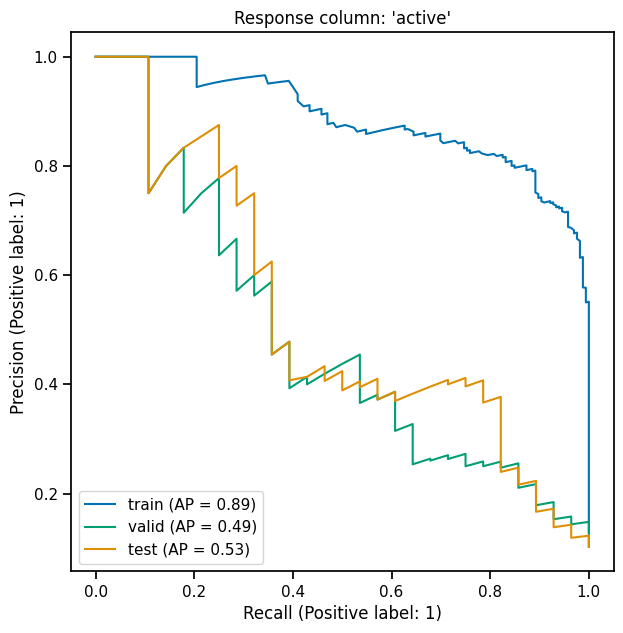

In [18]:
pp.plot_prec_recall_curve(mcc_wts_pipe)

## Conclusion

This concludes our series of tutorials highlighting the core functions of **[AMPL](https://github.com/ATOMScience-org/AMPL)**. We hope that completing these tutorials will provide you with the essential skills to train, evaluate and apply your own models for predicting chemical properties. In future versions of **[AMPL](https://github.com/ATOMScience-org/AMPL)**, we will release specialized tutorials covering some of **[AMPL](https://github.com/ATOMScience-org/AMPL)**'s more advanced capabilities, such as multitask modeling, transfer learning, feature importance analysis and more.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.